# Dictionary Learning

In [1]:
import os
import csv
from tqdm.notebook import tqdm_notebook
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.decomposition import DictionaryLearning
from sklearn.decomposition import MiniBatchDictionaryLearning
from skimage.util import view_as_windows
from skimage.metrics import structural_similarity as ssim

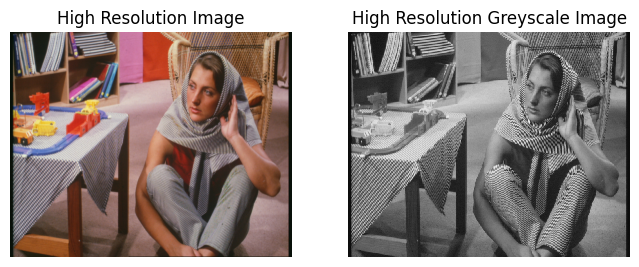

Shape of Image: (576, 720)


In [2]:
#Load an sample Image 
img_loc = "/Users/ltc/Documents/Python Scripts/MTP/Set14/original/barbara.png"
high_res_img = mpimg.imread(img_loc)


#convert from uint8 representation with values between 0 and 255 to 
#a floating point representation with values between 0 and 1
high_res_grey_img = cv.cvtColor(high_res_img, cv.COLOR_RGB2GRAY)

#Display the image
plt.figure(figsize=(8,10))

plt.subplot(1,2,1)
plt.imshow(high_res_img)
plt.axis("off")
plt.title("High Resolution Image", size=12)

plt.subplot(1,2,2)
plt.imshow(high_res_grey_img, vmin=0, vmax=1, cmap="gray", interpolation="nearest")
plt.axis("off")
plt.title("High Resolution Greyscale Image", size=12)
plt.show()

print(f"Shape of Image: {high_res_img.shape[:2]}")

## Low Resolution image
1. Downsampling: The high-resolution image is downsampled by a factor of 4, meaning that the low-resolution image will have 1/16th the number of pixels of the original.

2. Averaging: To create the pixel value for the low-resolution image, the method takes the average value of a 2x2 block of pixels in the original high-resolution image. This averaging process helps to reduce aliasing artifacts and preserves some of the original image details.

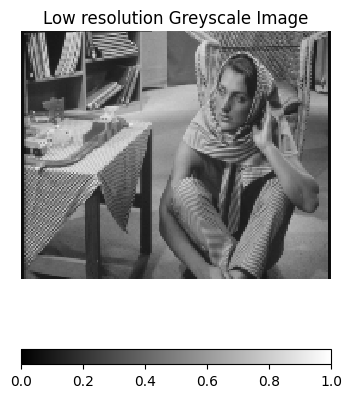

Shape of image: (144, 180)


In [67]:
#Downsampling the image by a factor of 4 and taking a avg 
#pixel value of 4 surrounding pixels

low_type = "LR1"

low_res_grey_img = (
    high_res_grey_img[::4, ::4] + 
    high_res_grey_img[1::4, ::4] + 
    high_res_grey_img[::4, 1::4] +
    high_res_grey_img[1::4, 1::4]
)

low_res_grey_img /= 4
height, width = low_res_grey_img.shape

plt.figure(figsize=(4,6))
plt.imshow(low_res_grey_img, vmin=0, vmax=1, cmap="gray", interpolation="nearest")
plt.title("Low resolution Greyscale Image")
plt.axis("off")
plt.colorbar(orientation='horizontal')
plt.show()

print(f"Shape of image: {height, width}")

Rather than taking the averaging value of 2X2 block of pixels here we apply a guassian kernel of 9X9 before we downsample. This is done to reduce high-frequency noise and artifacts.

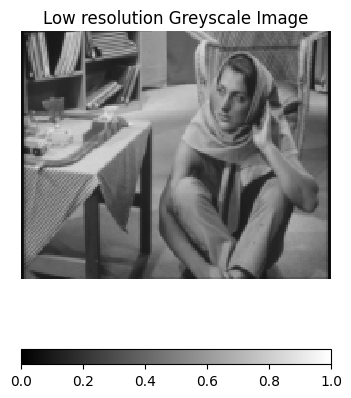

Shape of image: (144, 180)


In [3]:
low_type = "LR2"
kernel = (9,9)

blur_img = cv.GaussianBlur(high_res_grey_img, kernel, 1.5)
low_res_grey_img = cv.resize(blur_img, (0,0), fx=0.25, fy=0.25)
height, width = low_res_grey_img.shape

plt.figure(figsize=(4,6))
#Function that returns the current Axes instance on the current figure matching the given keyword arguments, 
#or creates one if none exists
ax = plt.gca()
im = ax.imshow(low_res_grey_img, vmin=0, vmax=1, cmap="gray", interpolation="nearest")
plt.title("Low resolution Greyscale Image", size=12)
plt.axis("off")
plt.colorbar(im, ax=ax, orientation='horizontal', location="bottom")
plt.show()

print(f"Shape of image: {low_res_grey_img.shape[:2]}")

## Extracting Patches
1. Overlapping Patch Extraction: Overlapping 8x8 patches are extracted from the low-resolution grayscale image. A sliding window of size 8x8 with a stride of 1 pixel in both horizontal and vertical dimensions is used, resulting in a total of 23,701 patches.

2. Reshaping: Each patch (8x8) is flattened into a 1D array of length 64, creating a 2D array with dimensions (number_of_patches, 64).

3. Standardization: The patches are standardized by subtracting the mean and dividing by the standard deviation of each pixel value across all patches. This step normalizes the data, which can help improve the performance of certain machine learning algorithms.

In [5]:
%%time
from sklearn.feature_extraction.image import extract_patches_2d

# Extract reference patches from the whole image
print("Extracting reference patches...\n")
patch_size = (5,5)

data = extract_patches_2d(low_res_grey_img, patch_size)
print(f"Shape of Data: {data.shape}\n")

data = data.reshape(data.shape[0], -1)
print(f"Shape of Data after flattening: {data.shape}\n")

#Standardize the data
data -= np.mean(data, axis=0)

data /= np.std(data, axis=0)
print(f"{data.shape[0]} patches extracted\n")

Extracting reference patches...

Shape of Data: (24640, 5, 5)

Shape of Data after flattening: (24640, 25)

24640 patches extracted

CPU times: user 11 ms, sys: 6.78 ms, total: 17.7 ms
Wall time: 14.5 ms


## Grid Search

* Define the search space: The search space consists of the following hyperparameters:
    * n_components
    * batch_size
    * alpha
    * max_iter

* Set up Cross-Validation: A 5-fold cross-validation is set up to evaluate the model's performance on different portions of the data.

* Grid Search: For each combination of hyperparameters, the model is trained and evaluated using the training and testing sets provided by the 5-fold cross-validation. The model's performance is assessed using the reconstruction error (mean squared error).

The goal of this grid search process is to identify the combination of hyperparameters that minimizes the reconstruction error on the test sets, using 5-fold cross-validation to ensure a reliable assessment of the model's performance.

### Choice of Hyper Parameters:
1. `n_components`: This parameter controls the number of dictionary atoms (basis vectors) that the model learns. A larger value for `n_components` may lead to a more expressive dictionary, resulting in better reconstruction and potentially lower MSE. However, increasing `n_components` can also lead to overfitting, especially if the value is too large compared to the number of samples in the dataset.

2. `alpha`: This parameter controls the sparsity of the learned representations. A higher value of `alpha` enforces sparser representations, which could help in reducing the complexity of the model and potentially prevent overfitting. However, if the value of `alpha` is too high, the model may underfit the data, resulting in a higher MSE.

Note:

`batch_size` and `max_iter`, can also affect the model's performance, but their impact is usually less significant compared to `n_components` and `alpha`

### Loss function

In [6]:
X = data

def reconstruction_error(estimator, X):
    
    dictionary = estimator.components_
    code = estimator.transform(X)
    
    #Reconstructed data matrix 
    X_reconstructed = np.matmul(code, dictionary)
    
    #MSE
    mse = np.mean((X - X_reconstructed)**2)
    
     # Use the negative value because GridSearchCV tries to maximize the score
    return -mse

### Code

In [7]:
param_grid = {
    
    "n_components" : [200, 250, 300, 350, 400],
    "batch_size" : [500],
    "alpha" : [0.75, 1.0, 1.25, 1.5],
    "max_iter" : [3],
}

In [8]:
from itertools import product

params_to_search = list(product(*param_grid.values()))
print(f"No of parameter combinations : {len(params_to_search)}")

No of parameter combinations : 20


In [11]:
%%time
from sklearn.model_selection import KFold
from time import time
import pickle
import os

#Store the various mse values
mse_results = []

def gridSearch(param_grid, best_params=None, best_score=np.inf, index=0):
    
    # Create a list of all possible parameter combinations
    param_combinations = list(product(*param_grid.values()))

    # Assuming X is your data
    n_samples = X.shape[0]
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

#     best_score = np.inf
#     best_params = None


    for params in tqdm_notebook(param_combinations[index:]):
        
        print(f"Processing parameter combination {params}")
        current_params = dict(zip(param_grid.keys(), params))
        scores = []

        for train_index, test_index in kfold.split(X):

            #Split the data into training and testing set
            X_train, X_test = X[train_index], X[test_index]

            #Start time
            t0 = time()

            #Training the model on training set
            dict_ = MiniBatchDictionaryLearning(**current_params)
            dict_.fit(X_train)

            #Make Predictions on test set 
            score = reconstruction_error(dict_, X_test)

            #end time
            dt = time() - t0
            minutes, seconds = divmod(dt, 60)

            scores.append(score)

        mean_score = np.mean(scores)
        # Print the elapsed time in minutes and seconds format
        print(f"MSE: {abs(score):.4f}, Elapsed time: {int(minutes)} minutes, {seconds:.2f} seconds")
        mse_results.append(mean_score)

        if mean_score < best_score:
            best_score = mean_score
            best_params = current_params

            #save the best model parameter to a file
            with open("session/best_params.pkl", "wb") as f:
                best_params_pkl = pickle.dumps((best_params, best_score))
                f.write(best_params_pkl)
        #save the current model parameter to a file
        with open("session/current_model.pkl", "wb") as f:
            current_model_pkl = pickle.dumps(param_combinations.index(params))
            f.write(current_model_pkl)

    print("Best hyperparameter found:")
    print(best_params)

CPU times: user 23 µs, sys: 1e+03 ns, total: 24 µs
Wall time: 31 µs


In [13]:
%%time
# %%capture cap --no-stderr
gridSearch(param_grid)

  0%|          | 0/20 [00:00<?, ?it/s]

Processing parameter combination (200, 500, 0.75, 3)


/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=4.642e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.234e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e

MSE: 0.0272, Elapsed time: 0 minutes, 26.82 seconds
Processing parameter combination (200, 500, 1.0, 3)


/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=9.918e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=4.750e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e

MSE: 0.0271, Elapsed time: 0 minutes, 20.60 seconds
Processing parameter combination (200, 500, 1.25, 3)


/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.704e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


MSE: 0.0261, Elapsed time: 0 minutes, 22.83 seconds
Processing parameter combination (200, 500, 1.5, 3)


/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.160e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:678: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.204e-02, previous alpha=8.204e-02, with an active set of 6 regressors.
  warnings.warn(


MSE: 0.0273, Elapsed time: 0 minutes, 22.41 seconds
Processing parameter combination (250, 500, 0.75, 3)


/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.139e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=7.222e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.

MSE: 0.0256, Elapsed time: 0 minutes, 31.20 seconds
Processing parameter combination (250, 500, 1.0, 3)


/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=8.460e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:678: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 20 iterations, alpha=5.021e-02, previous alpha=5.019e-02, with an active set of 11 regressors.
  warnings.warn(


MSE: 0.0254, Elapsed time: 0 minutes, 24.09 seconds
Processing parameter combination (250, 500, 1.25, 3)


/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.306e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:678: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 17 iterations, alpha=6.355e-02, previous alpha=6.355e-02, with an active set of 10 regressors.
  warnings.warn(
/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.338e-01, with an

MSE: 0.0252, Elapsed time: 0 minutes, 19.53 seconds
Processing parameter combination (250, 500, 1.5, 3)
MSE: 0.0255, Elapsed time: 0 minutes, 19.08 seconds
Processing parameter combination (300, 500, 0.75, 3)


/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:678: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=4.834e-02, previous alpha=4.833e-02, with an active set of 7 regressors.
  warnings.warn(
/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:678: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 17 iterations, alpha=3.749e-02, previous alpha=3.749e-02, with an active set of 10 regressors.
  warnings.warn(
/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.039e-01, with an active set of 2 regressors

MSE: 0.0248, Elapsed time: 0 minutes, 35.93 seconds
Processing parameter combination (300, 500, 1.0, 3)


/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.513e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.054e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:678: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of a

MSE: 0.0244, Elapsed time: 0 minutes, 26.79 seconds
Processing parameter combination (300, 500, 1.25, 3)


/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=6.081e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=5.337e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


MSE: 0.0240, Elapsed time: 0 minutes, 22.41 seconds
Processing parameter combination (300, 500, 1.5, 3)


/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.877e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.207e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:678: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of a

MSE: 0.0246, Elapsed time: 0 minutes, 16.97 seconds
Processing parameter combination (350, 500, 0.75, 3)


/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.881e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.234e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:678: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of 

MSE: 0.0234, Elapsed time: 0 minutes, 31.31 seconds
Processing parameter combination (350, 500, 1.0, 3)


/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=4.997e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:678: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 16 iterations, alpha=4.997e-02, previous alpha=4.997e-02, with an active set of 7 regressors.
  warnings.warn(
/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=6.575e-02, with an

MSE: 0.0233, Elapsed time: 0 minutes, 24.72 seconds
Processing parameter combination (350, 500, 1.25, 3)


/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.282e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=6.191e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e

MSE: 0.0232, Elapsed time: 0 minutes, 21.21 seconds
Processing parameter combination (350, 500, 1.5, 3)


/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.030e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.194e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e

MSE: 0.0241, Elapsed time: 0 minutes, 17.61 seconds
Processing parameter combination (400, 500, 0.75, 3)


/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=4.320e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:678: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=4.319e-02, previous alpha=4.319e-02, with an active set of 6 regressors.
  warnings.warn(
/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=9.625e-02, with an a

MSE: 0.0231, Elapsed time: 0 minutes, 32.98 seconds
Processing parameter combination (400, 500, 1.0, 3)


/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=8.403e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:678: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=5.039e-02, previous alpha=5.039e-02, with an active set of 5 regressors.
  warnings.warn(
/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=4.675e-02, with an 

MSE: 0.0224, Elapsed time: 0 minutes, 27.36 seconds
Processing parameter combination (400, 500, 1.25, 3)


/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.083e-01, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=7.606e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e

MSE: 0.0227, Elapsed time: 0 minutes, 25.60 seconds
Processing parameter combination (400, 500, 1.5, 3)
MSE: 0.0227, Elapsed time: 0 minutes, 47.20 seconds
Best hyperparameters found:
{'n_components': 200, 'batch_size': 500, 'alpha': 0.75, 'max_iter': 3}
CPU times: user 44min 35s, sys: 2min 28s, total: 47min 3s
Wall time: 43min 8s


In [40]:
#saving the logs to .txt file
with open("session/GridSearch_logs.txt", "w") as f:
    f.write(cap.stdout)

## Pandas for Current Grid Search

In [14]:
param_grid = {
    
    "n_components" : [200, 250, 300, 350, 400],
    "batch_size" : [500],
    "alpha" : [0.75, 1.0, 1.25, 1.5],
    "max_iter" : [3],
    "fit_algorithm" : ["lars"],
    "shuffle" : [True]
}

In [15]:
schema = {
    "parameters" : ["n_combinations", "patch_size","n_components", "alpha", "max_iter", "batch_size",  "fit_algorithm", "shuffle" ],
    "Description" : ["Number of parameter combination used in Grid Search", "Size of extracted Patch used for training", "Number of dictionary elements to extract","Sparsity controlling parameter","Maximum number of iterations over the complete dataset before stopping independently of any early stopping criterion heuristics", "Number of samples in each mini-batch", "The algorithm used, default=lars", "Whether to shuffle the samples before forming batches"]
}

In [21]:
params_to_search = list(product(*param_grid.values()))
n_combinations = list(range(1,len(params_to_search)+1))

#Making Data
rows = []

#concatenate mse values 
for i in range(len(params_to_search)):
    row = list(params_to_search[i])
    row.append(mse_results[i])
    row.append(patch_size)
    rows.append(row)
 

param_data = {
    "n_combinations" : list(range(1,len(params_to_search)+1)),
    "patch_size" : [row[7] for row in rows],
    "n_components" : [row[0] for row in rows],
    "batch_size" : [row[1] for row in rows],
    "alpha" : [row[2] for row in rows],
    "max_iter" : [row[3] for row in rows],
    "fit_algorithm" : [row[4] for row in rows],
    "shuffle" : [row[5] for row in rows],
    "mse_value" : [ -row[6] for row in rows]
}


### Creating dataframe from Dictionary

In [22]:
#Adding label to data frame 
df = pd.DataFrame(param_data)
schema_df = pd.DataFrame(schema)

df.set_index("n_combinations")

,patch_size,n_components,batch_size,alpha,max_iter,fit_algorithm,shuffle,mse_value
n_combinations,,,,,,,,
1,"(5, 5)",200,500,0.75,3,lars,True,0.028389
2,"(5, 5)",200,500,1.00,3,lars,True,0.027721
3,"(5, 5)",200,500,1.25,3,lars,True,0.027322
4,"(5, 5)",200,500,1.50,3,lars,True,0.027913
5,"(5, 5)",250,500,0.75,3,lars,True,0.026450
6,"(5, 5)",250,500,1.00,3,lars,True,0.026127
7,"(5, 5)",250,500,1.25,3,lars,True,0.026199
8,"(5, 5)",250,500,1.50,3,lars,True,0.026385
9,"(5, 5)",300,500,0.75,3,lars,True,0.025290


In [23]:
#Real world use case of indexing
schema_df.set_index("parameters")

,Description
parameters,
n_combinations,Number of parameter combination used in Grid S...
patch_size,Size of extracted Patch used for training
n_components,Number of dictionary elements to extract
alpha,Sparsity controlling parameter
max_iter,Maximum number of iterations over the complete...
batch_size,Number of samples in each mini-batch
fit_algorithm,"The algorithm used, default=lars"
shuffle,Whether to shuffle the samples before forming ...


### Saving Grid Search

In [24]:
# Check if the CSV file exists
file_name = 'GridSearch_Parameters.csv'
file_exists = os.path.isfile(file_name)

# Save the DataFrame to a CSV file or append to it if it exists
df.to_csv(file_name, mode='a', index=False, header=not file_exists)

In [25]:
# Check if the CSV file exists
file_name = 'GridSearch_Schema.csv'
file_exists = os.path.isfile(file_name)

# Save the DataFrame to a CSV file or append to it if it exists
schema_df.to_csv(file_name, mode='a', index=False, header=not file_exists)

### Best Parameters

In [26]:
#Take the best Parameter out from pandas frame
filt = (df["mse_value"] == df["mse_value"].min())

In [27]:
best_param = df.loc[filt, "patch_size":]
best_param["Image Type"] = [low_type]
best_param

,patch_size,n_components,batch_size,alpha,max_iter,fit_algorithm,shuffle,mse_value,Image Type
17,"(5, 5)",400,500,1.0,3,lars,True,0.023209,LR2


### Saving Best Parameters

In [28]:
# Check if the CSV file exists
file_name = 'Best_Parameters.csv'
file_exists = os.path.isfile(file_name)

# Save the DataFrame to a CSV file or append to it if it exists
best_param.to_csv(file_name, mode='a', index=False, header=not file_exists)

### Scatter Plot
To visualize the relationship between the hyperparameters and the model performance metric obtained from the grid search results

In [30]:
# n_components_val = [params[0] for params, mean_score in mse_results]
# alpha_val = [params[2] for params, mean_score in mse_results]
# mse_val = [abs(mean_score) for params, mean_score in mse_results]

In [31]:
# #Create scatter plots for each hyperparameter against average MSE values
# plt.figure(figsize=(6, 4))

# plt.subplot(1, 2, 1)
# plt.scatter(n_components_val, mse_val)
# plt.xlabel("n_components")
# plt.ylabel('Average MSE')


# plt.subplot(1,2,2)
# plt.scatter(alpha_val, mse_val)
# plt.xticks(alpha_val)
# plt.xlabel('alpha')
# plt.ylabel('Average MSE')

# plt.tight_layout()
# plt.show()

## For Restoring Grid Search

In [34]:
# Load the best param from the file if it exsits
if os.path.exists("session/best_params.pkl"):
    with open("session/best_params.pkl", "rb") as f:
        best_params, best_score = pickle.loads(f)
        
# Load the current parameters and the index from the file if it exists
if os.path.exists("session/current_model.pkl"):
    with open("current_model.pkl", "rb") as f:
        current_index = pickle.loads(f)
        
# Resume the gridsearch
gridSearch(param_grid, best_params=best_params, best_score=best_score, index=current_index)

In [124]:
#saving the logs to .txt file
with open("session/GridSeach.txt", "w") as f:
    f.write(cap.stdout)

## Learning the dictionary from reference patches

The dictionary is learned from the reference patches using the MiniBatchDictionaryLearning algorithm with the best hyperparameters found during the grid search.

* Define hyperparameters: The best hyperparameters found in the previous grid search are defined (n_components, batch_size, alpha, and max_iter).

* Initialize the model: A MiniBatchDictionaryLearning instance is created using the defined hyperparameters, with additional settings for shuffling the data and enabling verbose output.

* Fit the model: The model is trained on the reference patches (data) using the fit method.

In [35]:
batch_dl = MiniBatchDictionaryLearning(
    n_components = int(best_param["n_components"]),
    batch_size = int(best_param["batch_size"]),
    alpha = float(best_param["alpha"]), #sparsity constraint
    max_iter = int(best_param["max_iter"]), #times the algorithm will loop over all the mini batches before stopping
    shuffle = True,
    verbose = 1
)

In [36]:
%%time
%%capture cap --no-stderr

t0 = time()
D = batch_dl.fit(data).components_
dt = time() - t0

print(f"{batch_dl.n_iter_} iterations / {batch_dl.n_steps_} steps in {dt:.2f}.")

/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.346e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=5.138e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


CPU times: user 38.9 s, sys: 1.65 s, total: 40.5 s
Wall time: 39.5 s


In [37]:
#saving the logs to .txt file
with open("Patches.txt", "w") as f:
    f.write(cap.stdout)

## Loss Function Graph

In [38]:
#Parsing .txt file 
with open("Patches.txt", "r") as f:
    lines = f.readlines()

with open("Patches.csv", "w") as f_:

    header = ["Minibatch step", "mean batch cost", "ewa cost"]
    writer = csv.DictWriter(f_, fieldnames=header)
    writer.writeheader()
    
    for line in lines[1:]:
        
        if line.startswith("Minibatch"):
            line = line.lower()
            tokens = line.split(": ")
            step_info = tokens[0].split(" ")
            current_step, total_step = step_info[2].split("/")
            try:
                mean = float(tokens[2])
                mean = f"{mean:.2f}"
            except ValueError:
                mean = float(tokens[2].split(",")[0])
                mean = f"{mean:.2f}"
            ewa_mean = None
            if len(tokens) > 3:
                ewa_mean = float(tokens[3].strip())
                ewa_mean = f"{ewa_mean:.2f}"
            writer.writerow({"Minibatch step": current_step, "mean batch cost": mean, "ewa cost":ewa_mean})
    print(f"Successfully Stored as CSV\n")


Successfully Stored as CSV



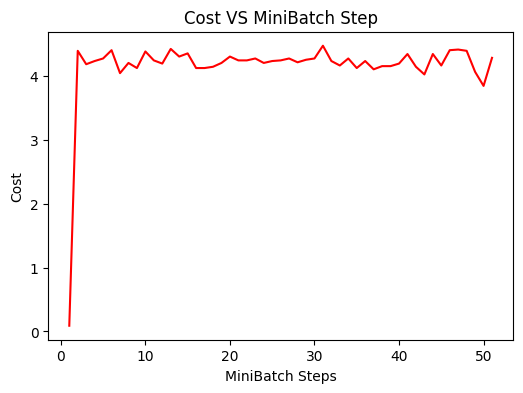

In [39]:
step = []
mean = []
ewa_mean = []
with open("Patches.csv", "r") as f:
    reader = csv.DictReader(f)
    
    for line in reader:
        step.append(float(line["Minibatch step"]))
        mean.append(float(line["mean batch cost"]))
        try: 
            ewa_mean.append(float(line["ewa cost"]))
        except ValueError:
            ewa_mean.append(0)

plt.figure(figsize=(6,4))
plt.plot(step, mean, "r", label="Mean batch cost")
# plt.plot(step, ewa_mean, "b", label="EWA cost")
plt.xlabel("MiniBatch Steps")
plt.ylabel("Cost")
plt.title("Cost VS MiniBatch Step")
plt.show()

## Sparse code

To generate sparse codes from the code provided, the following steps are performed using the data (extracted patches):

* Set transform parameters: By Configuring the MiniBatchDictionaryLearning model with the desired transform algorithm and the number of non-zero coefficients. The Least Angle Regression (LARS) algorithm is used as the transform algorithm, and the number of non-zero coefficients is set to 6. These parameters determine the sparsity of the codes, ensuring that only a limited number of dictionary atoms contribute to the representation of each patch.

* Transform data: The transform method finds a sparse representation of the input patches using a linear combination of the learned dictionary atoms, while adhering to the specified sparsity constraints.

In [40]:
print(D.shape)

(400, 25)


In [41]:
%%time
"""
Adds the mean (intercept) of the extracted patches to each patch, 
This is done to re-center the patches around their original intensity values 
before the patches were extracted.
"""
intercept = np.mean(data, axis=0)


# batch_dl.set_params(transform_algorithm="omp", transform_n_nonzero_coefs=10)
batch_dl.set_params(transform_algorithm="lars", transform_n_nonzero_coefs=6)

code = batch_dl.transform(data)
patches = np.dot(code, D)

patches += intercept
patches = patches.reshape(data.shape[0], patch_size[0], patch_size[1])

CPU times: user 35.4 s, sys: 711 ms, total: 36.1 s
Wall time: 41.8 s


### Compresibilty

In [42]:
sparsity = np.sum(code == 0)/(code.shape[0]*code.shape[1])
non_zero_coefs = code.shape[0]*code.shape[1]*(1-sparsity)
print(f"Sparsity : {sparsity:.2f}")
print(f"Total coefficients : {code.shape[0]*code.shape[1]}")
print(f"No. of non zero coefficients: {non_zero_coefs:.2f}")

Sparsity : 0.99
Total coefficients : 9856000
No. of non zero coefficients: 143261.00


In [43]:
print(patches.shape)

(24640, 5, 5)


## Reconstruction

It takes a set of overlapping patches extracted from an image and reconstructs the original image from those patches.


* Input: The function takes two arguments:
    * An array of patches (typically 2D or 3D), where each patch represents a small portion of the original image.
    * The dimensions of the original image (height and width).

* Overlap Handling: Since the patches often overlap, the function needs to decide how to combine the overlapping regions to reconstruct the image. It does this by taking the average of the overlapping pixel values. This can help to minimize the artifacts caused by patch extraction and reconstruction.

* Reconstruction: The function iterates through the patches and places them back into their original positions in the image based on their coordinates. When multiple patches overlap, it computes the average of the overlapping pixels and assigns the resulting value to the corresponding position in the reconstructed image.

* Output: The function returns the reconstructed image with the specified dimensions (height and width).

In [44]:
from sklearn.feature_extraction.image import reconstruct_from_patches_2d

reconstructed_img = reconstruct_from_patches_2d(
        patches, (height, width)
)
# Rescale the pixel values to between 0 and 255
reconstructed_img = (reconstructed_img - reconstructed_img.min()) / (reconstructed_img.max() - reconstructed_img.min()) * 255

# Convert the pixel values to integers
reconstructed_img = reconstructed_img.astype(np.uint8)

## Results
We applied the MiniBatch Dictionary Learning approach to image processing and performed a grid search to identify the best hyperparameters for reconstructing low-resolution images. We evaluated the performance of the algorithm on two different patch sizes, (8,8) and (5,5), and compared the results obtained with different parameter combinations.

Our results showed that the best parameters for each patch size differed, with higher values of n_components for patch size (5,5). 

The reconstruction quality was evaluated using the structural similarity index (SSIM), which measures the similarity between the reconstructed and original images. For patch size (8,8), the algorithm achieved an SSIM of 0.92, while for patch size (5,5), the algorithm achieved an SSIM of 0.96. These results suggest that the MiniBatch Dictionary Learning approach is effective in capturing essential image features and producing high-quality reconstructions.

In conclusion, our results demonstrate the importance of hyperparameter tuning in achieving optimal performance with MiniBatch Dictionary Learning for image processing. 

In [45]:
file_name = 'Best_Parameters.csv'
df = pd.read_csv(file_name)
df

,patch_size,n_components,batch_size,alpha,max_iter,fit_algorithm,shuffle,mse_value,Image Type
0,"(5, 5)",400,500,1.50,3,lars,True,0.023196,LR2
1,"(8, 8)",200,500,1.50,3,lars,True,0.022179,LR2
2,"(5, 5)",320,500,0.75,3,lars,True,0.023325,LR2
3,"(5, 5)",200,500,0.75,3,lars,True,0.023798,LR2
4,"(5, 5)",400,500,1.00,3,lars,True,0.023209,LR2


In [46]:
schema_df

,parameters,Description
0,n_combinations,Number of parameter combination used in Grid S...
1,patch_size,Size of extracted Patch used for training
2,n_components,Number of dictionary elements to extract
3,alpha,Sparsity controlling parameter
4,max_iter,Maximum number of iterations over the complete...
5,batch_size,Number of samples in each mini-batch
6,fit_algorithm,"The algorithm used, default=lars"
7,shuffle,Whether to shuffle the samples before forming ...


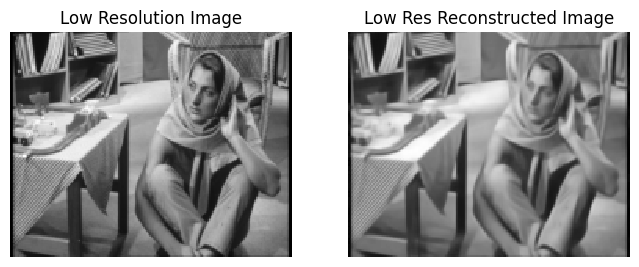

In [47]:
plt.figure(figsize=(8,10))

plt.subplot(1,2,1)
plt.imshow(low_res_grey_img, cmap="gray", interpolation="nearest")
plt.axis("off")
plt.title("Low Resolution Image")

plt.subplot(1,2,2)
plt.imshow(reconstructed_img, cmap="gray", interpolation="nearest")
plt.axis("off")
plt.title("Low Res Reconstructed Image")
plt.show()


## SSIM

In [48]:
#Change the dtype of images
low_res_grey_img = (low_res_grey_img*255).astype(np.uint8)

# reconstructed_img = (reconstructed_img*255).astype(np.uint8)

# Calculate the SSIM between the reconstructed and original images
ssim_score = ssim(low_res_grey_img, reconstructed_img)

# Print the SSIM score
print(f"SSIM score between Reconstructed and Original: {ssim_score:.2f}")

SSIM score between Reconstructed and Original: 0.96


## Reconstruction Error

In [ ]:
# X = np.random.randn(n_samples, n_features)

# # Split the data matrix into training and test sets
# X_train = X[:800] # use the first 800 samples for training
# X_test = X[800:] # use the last 200 samples for testing

# # Define the sparsity parameter alpha
# alpha = 1

# # Create an instance of MiniBatchDictionaryLearning with some parameters
# model = MiniBatchDictionaryLearning(n_components=10, alpha=alpha, max_iter=100, batch_size=50)

# # Fit the model to the training set
# model.fit(X_train)

# # Transform the training and test sets using the learned dictionary
# U_train = model.transform(X_train)
# U_test = model.transform(X_test)

# # Reconstruct the training and test sets using the learned code matrices
# X_train_reconstructed = U_train.dot(model.components_)
# X_test_reconstructed = U_test.dot(model.components_)

# # Compute the reconstruction error for the training and test sets using mean squared error metric
# train_error = mean_squared_error(X_train, X_train_reconstructed)
# test_error = mean_squared_error(X_test, X_test_reconstructed)

# # Print the reconstruction errors
# print("Train error:", train_error)
# print("Test error:", test_error)

In [123]:
#DUMP
# intercept = np.mean(data, axis=0)

# transform_algorithms = [
#     ("Orthogonal Matching Pursuit\n1 atom", "omp", {"transform_n_nonzero_coefs": 1}),
#     ("Orthogonal Matching Pursuit\n2 atoms", "omp", {"transform_n_nonzero_coefs": 2}),
#     ("Least-angle regression\n4 atoms", "lars", {"transform_n_nonzero_coefs": 4}),
#     ("Thresholding\n alpha=0.1", "threshold", {"transform_alpha": 0.1}),
# ]

# reconstructions = {}
# for title, transform_algorithm, kwargs in transform_algorithms:
#     print(title + "...")
#     reconstructions[title] = low_res_grey_img.copy()
#     t0 = time()
#     batch_dl.set_params(transform_algorithm=transform_algorithm, **kwargs)
#     code = batch_dl.transform(data)
#     patches = np.dot(code, D)

#     patches += intercept
#     patches = patches.reshape(len(data), *patch_size)
#     if transform_algorithm == "threshold":
#         patches -= patches.min()
#         patches /= patches.max()
#     reconstructions[title] = reconstruct_from_patches_2d(
#         patches, (height, width)
#     )
#     dt = time() - t0
#     print("done in %.2fs." % dt)

In [ ]:
# def print_loss(model, X):
#     # Get dictionary and code from model
#     D = model.components_
#     U = model.transform(X)
#     # Reconstruct data using dictionary and code
#     X_reconstructed = np.dot(U, D)
#     # Calculate mean squared error between original and reconstructed data
#     mse = mean_squared_error(X, X_reconstructed)
#     # Print loss value
#     print(f"Loss: {mse}")